In [110]:
# !pip install kaggle -q

In [83]:
# Imports padrão
import os
import zipfile
import random
from glob import glob
from collections import Counter
import shutil
import json

# Manipulação e visualização de dados
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Processamento de imagens
from PIL import Image

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# Deep Learning (Keras)
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.vgg16 import preprocess_input # Função de pré-processamento do VGG16
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model



# Importação dos Dados

In [3]:
ZIP_FILE_PATH = 'HousePlantSpecies.zip'
BASE_PATH = os.path.join(
    'datasets',
    'plant_species_dataset'
)

# Garante que o diretório exista
os.makedirs(BASE_PATH, exist_ok=True)

try:
    # Extrai o ZIP
    with zipfile.ZipFile(ZIP_FILE_PATH, 'r') as zip_ref:
        zip_ref.extractall(BASE_PATH)

    print(f"Extração concluída com sucesso em: {BASE_PATH}")


except FileNotFoundError:
    print(f"ERRO: Arquivo ZIP não encontrado em: {ZIP_FILE_PATH}")
except Exception as e:
    print(f"Ocorreu um erro durante a extração: {e}")


Extração concluída com sucesso em: datasets\plant_species_dataset


 # Entendimento dos Dados

In [4]:
BASE_PATH = os.path.join('datasets', 'plant_species_dataset', 'house_plant_species')

try:
    # Lista as subpastas, que representam as classes (Espécie_Doença)
    classes = sorted(
        d for d in os.listdir(BASE_PATH)
        if os.path.isdir(os.path.join(BASE_PATH, d)) 
    )

    for i, class_name in enumerate(classes): 
        print(f"Classe {i+1}: {class_name}")

except FileNotFoundError:
    print(f"ERRO: O diretório base '{BASE_PATH}' não foi encontrado. Verifique se o ZIP foi extraído corretamente.")
except Exception as e:
    print(f"Ocorreu um erro durante a inspeção da estrutura: {e}")

Classe 1: African Violet (Saintpaulia ionantha)
Classe 2: Aloe Vera
Classe 3: Anthurium (Anthurium andraeanum)
Classe 4: Areca Palm (Dypsis lutescens)
Classe 5: Asparagus Fern (Asparagus setaceus)
Classe 6: Begonia (Begonia spp.)
Classe 7: Bird of Paradise (Strelitzia reginae)
Classe 8: Birds Nest Fern (Asplenium nidus)
Classe 9: Boston Fern (Nephrolepis exaltata)
Classe 10: Calathea
Classe 11: Cast Iron Plant (Aspidistra elatior)
Classe 12: Chinese Money Plant (Pilea peperomioides)
Classe 13: Chinese evergreen (Aglaonema)
Classe 14: Christmas Cactus (Schlumbergera bridgesii)
Classe 15: Chrysanthemum
Classe 16: Ctenanthe
Classe 17: Daffodils (Narcissus spp.)
Classe 18: Dracaena
Classe 19: Dumb Cane (Dieffenbachia spp.)
Classe 20: Elephant Ear (Alocasia spp.)
Classe 21: English Ivy (Hedera helix)
Classe 22: Hyacinth (Hyacinthus orientalis)
Classe 23: Iron Cross begonia (Begonia masoniana)
Classe 24: Jade plant (Crassula ovata)
Classe 25: Kalanchoe
Classe 26: Lilium (Hemerocallis)
Classe

In [ ]:
class_counts = Counter()
total_imagens = 0

# Faz a contagem em todas as classes
for class_name in classes:
    class_path = os.path.join(BASE_PATH, class_name)
    count = len([f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))])
    class_counts[class_name] = count
    total_imagens += count

df_counts = pd.DataFrame(class_counts.items(), columns=['Classe', 'Contagem'])
df_counts = df_counts.sort_values(by='Contagem', ascending=False)
std_dev = df_counts['Contagem'].std()

print(f"Total Geral de Imagens no Dataset: {total_imagens}")
print(f"Total de Classes: {len(classes)}")

print(df_counts.head())
print(df_counts.tail())
print(f"\nDesvio Padrão da Contagem de Imagens: {std_dev:.2f}")

Total Geral de Imagens no Dataset: 13825
Total de Classes: 47
                                     Classe  Contagem
28  Monstera Deliciosa (Monstera deliciosa)       513
18           Dumb Cane (Dieffenbachia spp.)       494
12            Chinese evergreen (Aglaonema)       486
25                    Lilium (Hemerocallis)       444
2          Anthurium (Anthurium andraeanum)       434
                                   Classe  Contagem
3           Areca Palm (Dypsis lutescens)       176
6   Bird of Paradise (Strelitzia reginae)       170
4     Asparagus Fern (Asparagus setaceus)       159
24                              Kalanchoe       120
45                                  Yucca        60

Desvio Padrão da Contagem de Imagens: 97.27


C:\Users\a-a-c\AppData\Local\Temp\ipykernel_6776\3534163648.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Contagem', y='Classe', data=df_counts, palette="viridis")


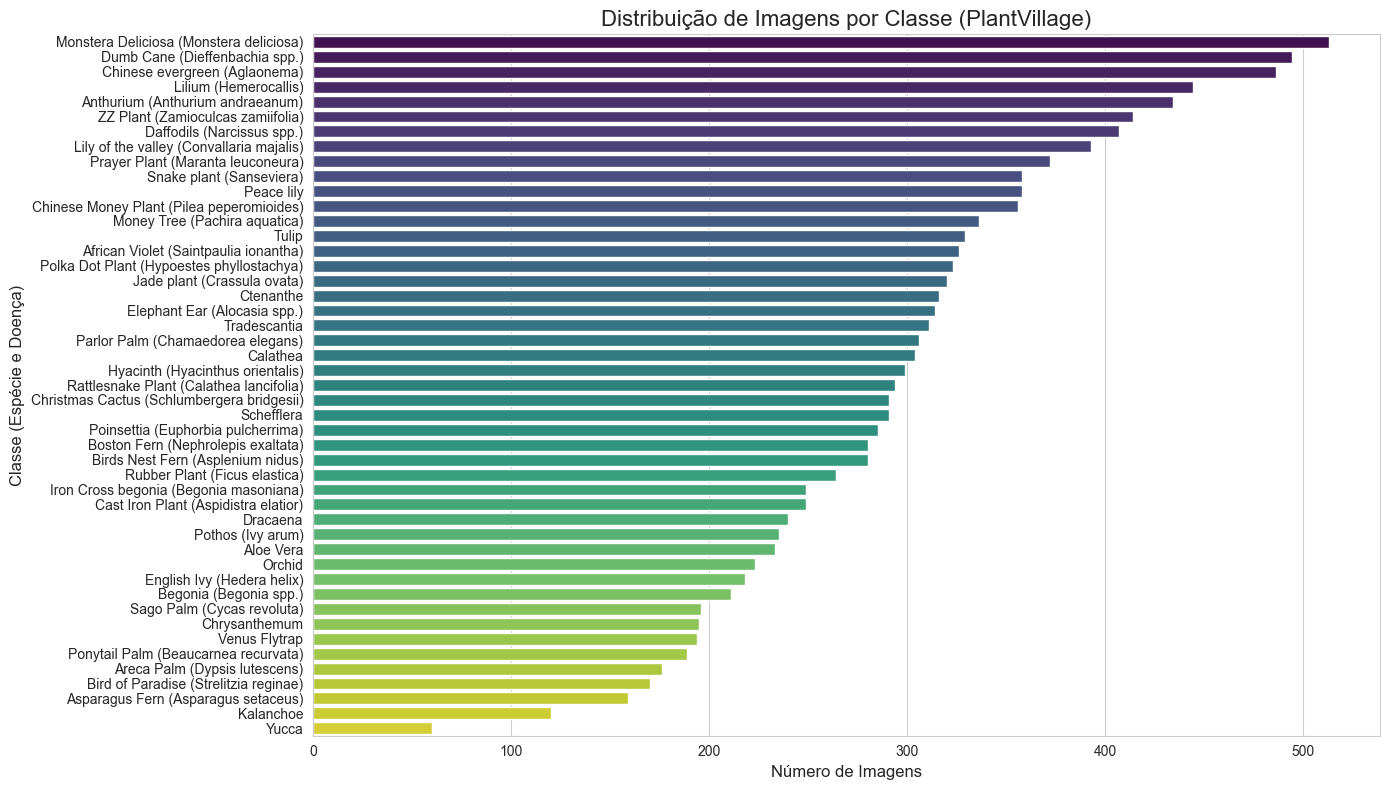

In [6]:
plt.figure(figsize=(14, 8))
sns.set_style("whitegrid")

# Gráfico de barras - Distribuição de Imagens por Classe
sns.barplot(x='Contagem', y='Classe', data=df_counts, palette="viridis")

plt.title('Distribuição de Imagens por Classe (PlantVillage)', fontsize=16)
plt.xlabel('Número de Imagens', fontsize=12)
plt.ylabel('Classe (Espécie e Doença)', fontsize=12)

plt.tight_layout()
plt.show()

In [7]:
# Análise de Dimensões, Canais de Cor  e Formato
image_info = []
sample_size = 50 

for class_name in classes:
    class_path = os.path.join(BASE_PATH, class_name)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]
    
    # Amostra um subconjunto para eficiência
    if len(image_files) > sample_size:
        sample_files = np.random.choice(image_files, sample_size, replace=False)
    else:
        sample_files = image_files

    # Processa as imagens amostradas
    for image_file in sample_files:
        try:
            img_path = os.path.join(class_path, image_file)
            with Image.open(img_path) as img:
                info = {
                    'Classe': class_name,
                    'Dimensão': img.size,
                    'Canais': len(img.getbands()),
                    'Formato': img.format
                }
                image_info.append(info)
        except Exception as e:
            print(f"ERRO ao processar {img_path}: {e}")

df_image_info = pd.DataFrame(image_info)

print("Análise de Dimensões")
print(df_image_info['Dimensão'].value_counts())
print("\nAnálise de Canais de Cor")
print(df_image_info['Canais'].value_counts())
print("\nAnálise de Formato")
print(df_image_info['Formato'].value_counts())

Análise de Dimensões
Dimensão
(1000, 1000)    79
(1024, 1024)    53
(800, 800)      53
(1200, 1200)    35
(1200, 1600)    34
                ..
(407, 610)       1
(2304, 3072)     1
(2133, 2560)     1
(2976, 3968)     1
(2263, 2932)     1
Name: count, Length: 1102, dtype: int64

Análise de Canais de Cor
Canais
3    2280
4      44
1      26
Name: count, dtype: int64

Análise de Formato
Formato
JPEG    2238
PNG       99
WEBP      12
MPO        1
Name: count, dtype: int64


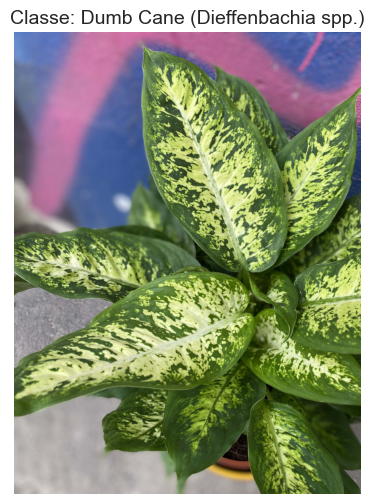

Visualizando: datasets\plant_species_dataset\house_plant_species\Dumb Cane (Dieffenbachia spp.)\384.jpg


In [34]:
random_class = random.choice(classes)
class_path = os.path.join(BASE_PATH, random_class)
image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.png'))]

if image_files:
    random_image_file = random.choice(image_files)
    random_image_path = os.path.join(class_path, random_image_file)
    
    try:
        with Image.open(random_image_path) as img:
            plt.figure(figsize=(6, 6))
            plt.imshow(img)
            plt.title(f"Classe: {random_class}", fontsize=14)
            plt.axis('off')
            plt.show()
            print(f"Visualizando: {random_image_path}")
            
    except Exception as e:
        print(f"ERRO ao carregar ou exibir imagem {random_image_path}: {e}")
else:
    print(f"ERRO: Nenhuma imagem encontrada na classe {random_class}")

# Preparação dos Dados

In [ ]:
PROCESSED_BASE = os.path.join('datasets', 'plant_species_dataset', 'processed_data')
TRAIN_DIR = os.path.join(PROCESSED_BASE, 'train')
VAL_DIR = os.path.join(PROCESSED_BASE, 'val')
TEST_DIR = os.path.join(PROCESSED_BASE, 'test')


Total Geral de Imagens no Dataset: 0
Total de Classes: 47


In [ ]:
# Configuração das proporções
# 70% Treino, 15% Validação, 15% Teste
TEST_SPLIT_TOTAL = 0.30  # 30% restante para Validação + Teste
VAL_TEST_PERCENTAGE = 0.15 # Porcentagem de cada um (15%)
RANDOM_STATE = 42

filepaths = []
labels = []

for class_name in os.listdir(BASE_PATH):
    class_path = os.path.join(BASE_PATH, class_name)
    if os.path.isdir(class_path):
        for image_file in os.listdir(class_path):
            if image_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                filepaths.append(os.path.join(class_path, image_file))
                labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
print(f"Dataset Total: {len(df)} imagens.")

# Treino (70%) vs. Validação/Teste (30%)
df_train, df_val_test = train_test_split(
    df, 
    test_size=TEST_SPLIT_TOTAL, 
    stratify=df['label'], 
    random_state=RANDOM_STATE
)

# 3. Validação (15%) e Teste (15%)
test_split_ratio = VAL_TEST_PERCENTAGE / TEST_SPLIT_TOTAL  # 0.15 / 0.30 = 0.5
df_val, df_test = train_test_split(
    df_val_test, 
    test_size=test_split_ratio, 
    stratify=df_val_test['label'], 
    random_state=RANDOM_STATE
)

def create_structure(base_dir, df_split):
    os.makedirs(base_dir, exist_ok=True)
    for class_name in df_split['label'].unique():
        os.makedirs(os.path.join(base_dir, class_name), exist_ok=True)

os.makedirs(PROCESSED_BASE, exist_ok=True) 
create_structure(TRAIN_DIR, df_train)
create_structure(VAL_DIR, df_val)
create_structure(TEST_DIR, df_test)


print(f"Treino (Aprox. 70%): {len(df_train)} imagens")
print(f"Validação (Aprox. 15%): {len(df_val)} imagens")
print(f"Teste (15%): {len(df_test)} imagens")
print(f"Verificação (Total): {len(df_train) + len(df_val) + len(df_test)} imagens")

Dataset Total: 14620 imagens.
Treino (Aprox. 70%): 10234 imagens
Validação (Aprox. 15%): 2193 imagens
Teste (15%): 2193 imagens
Verificação (Total): 14620 imagens


In [55]:
def copy_files_to_splits(df_split, target_dir):
    copied_count = 0
    total_count = len(df_split)
    
    for index, row in df_split.iterrows():
        src_path = row['filepath']
        class_name = row['label']
        
        dest_class_dir = os.path.join(target_dir, class_name)
        file_name = os.path.basename(src_path)
        dest_path = os.path.join(dest_class_dir, file_name)
        
        try:
            shutil.copy2(src_path, dest_path)
            copied_count += 1
        except Exception as e:
            print(f"ERRO ao copiar {src_path}: {e}")

    print(f"Total copiado: {copied_count}/{total_count}")


# Executa a cópia para cada split
copy_files_to_splits(df_train, TRAIN_DIR)
copy_files_to_splits(df_val, VAL_DIR)
copy_files_to_splits(df_test, TEST_DIR)

Total copiado: 10234/10234
Total copiado: 2193/2193
Total copiado: 2193/2193


In [82]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
SEED = 42

# Data Augmentation para Treino
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Aplica a normalização específica do VGG16
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Normalização para Validação e Teste
val_test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)
validation_generator = val_test_datagen.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    seed=SEED
)
test_generator = val_test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Mapeamento de Classes
class_names = list(train_generator.class_indices.keys())
num_classes = len(class_names)
class_map = train_generator.class_indices

print(f"\nNúmero de Classes Processadas: {num_classes}")
print("Mapeamento de Classes:")
print(json.dumps(class_map, indent=2, ensure_ascii=False))

Found 10234 images belonging to 47 classes.
Found 2193 images belonging to 47 classes.
Found 2193 images belonging to 47 classes.

Número de Classes Processadas: 47
Mapeamento de Classes:
{
  "African Violet (Saintpaulia ionantha)": 0,
  "Aloe Vera": 1,
  "Anthurium (Anthurium andraeanum)": 2,
  "Areca Palm (Dypsis lutescens)": 3,
  "Asparagus Fern (Asparagus setaceus)": 4,
  "Begonia (Begonia spp.)": 5,
  "Bird of Paradise (Strelitzia reginae)": 6,
  "Birds Nest Fern (Asplenium nidus)": 7,
  "Boston Fern (Nephrolepis exaltata)": 8,
  "Calathea": 9,
  "Cast Iron Plant (Aspidistra elatior)": 10,
  "Chinese Money Plant (Pilea peperomioides)": 11,
  "Chinese evergreen (Aglaonema)": 12,
  "Christmas Cactus (Schlumbergera bridgesii)": 13,
  "Chrysanthemum": 14,
  "Ctenanthe": 15,
  "Daffodils (Narcissus spp.)": 16,
  "Dracaena": 17,
  "Dumb Cane (Dieffenbachia spp.)": 18,
  "Elephant Ear (Alocasia spp.)": 19,
  "English Ivy (Hedera helix)": 20,
  "Hyacinth (Hyacinthus orientalis)": 21,
  "I

# Modelagem

# Avaliação